In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs109b_hw2.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 

## Homework 2: Bayesian Analysis



**Harvard University**<br/>
**Spring 2024**<br/>
**Instructors**: Pavlos Protopapas & Alex Young


<hr style="height:2pt">

In [2]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/"
    "content/styles/cs109.css"
).text
HTML(styles)

<div style = "background: lightsalmon; border: thin solid black; border-radius: 2px; padding: 5px">

### Instructions
- To submit your notebook, follow the instructions given in on the Canvas assignment page.
- Plots should be legible and interpretable *without having to refer to the code that generated them*. They should includelabels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you believe the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so simply passing all tests may not be sufficient for full credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output.
- Feel free to add additional code or markdown cells as needed.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**
</div>

In [3]:
import time
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy.special import expit

In [4]:
# measure notebook runtime
time_start = time.time()

## Notebook Contents
<a id="contents"></a>
- **Dataset Information**
- **Bayesian Logistic Regression with Varying-Intercept Description**
- [**Part 1: Varying-Intercept Model (Simulated Response Variable)**](#part1)
- [**Part 2: Varying-Intercept Model (Real Data)**](#part2)
- [**Part 3: Varying-Coefficients Model**](#part3)
- [**Part 4: Prediction & Model Selection**](#part4)

## Dataset Information

### Contraceptive Usage by Bangladeshi Women

For this assignment, you are provided with datasets `train.csv` and `test.csv` which contain details of contraceptive usage among 1,934 Bangladeshi women.

There are four attributes for each woman along with a response variable, `contraceptive_use`, indicating if she uses contraceptives. The four attributes include:

* `district`: code identifying the district in which the woman lives (60 districts in total)
* `urban`: type of region of residence (binary)
* `living.children`: number of living children
* `age-mean`: age of the woman (in years, centered around mean)

The task is to build a classification model that can predict if a given woman uses contraceptives.

The following cell will load and inspect the train and test datasets.

TRAINING DATA INFO:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   district           967 non-null    int64  
 1   urban              967 non-null    int64  
 2   living.children    967 non-null    int64  
 3   age_mean           967 non-null    float64
 4   contraceptive_use  967 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 37.9 KB

TEST DATA INFO:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   district           967 non-null    int64  
 1   urban              967 non-null    int64  
 2   living.children    967 non-null    int64  
 3   age_mean           967 non-null    float64
 4   contraceptive_use  967 non-null    int64  
dtypes: float64(1), int64(4)
m

,district,urban,living.children,age_mean,contraceptive_use
0,35,0,4,2.4400,0
1,22,0,2,-1.5599,1
2,29,0,2,-8.5599,1


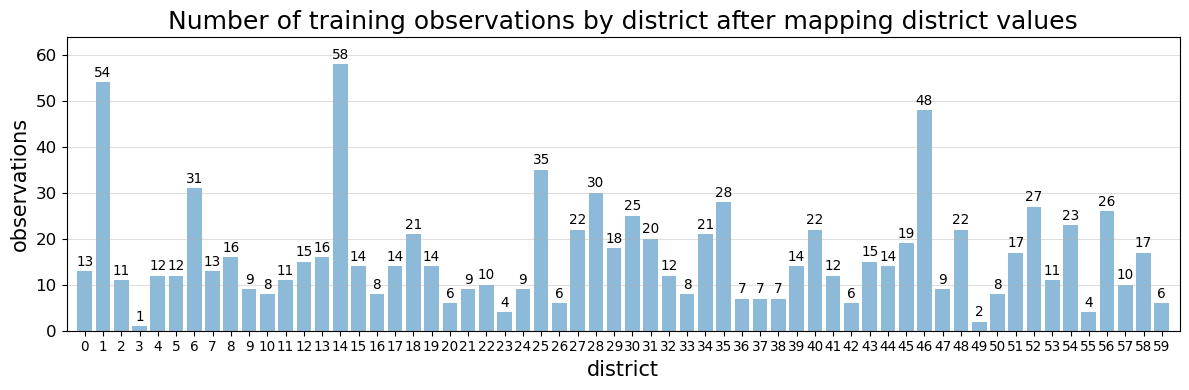

In [5]:
# loading and inspecting the data
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

# print dataset summary info for ease of reference
print("TRAINING DATA INFO:\n")
df_train.info()
print("\nTEST DATA INFO:\n")
df_test.info()
print("\nTRAINING DATA SUMMARY STATS:\n")
print(df_train.describe())
print("\nTRAINING DATA FIRST ROWS OF DATA:")
display(df_train.head(3))
print()

# And plot observation counts by district also just for reference
def plot_value_counts(value_counts, var_name, font_perc):
    """Generates barplot from pandas value_counts series"""
    fig, ax = plt.subplots(figsize=(12, 4))

    max_y = max(value_counts.values)
    n_cats = len(value_counts)

    ax.bar(range(n_cats), value_counts.values, alpha=0.5)

    for x, y in enumerate(value_counts):
        ax.text(
            x, y+max_y*.02,
            "{:,}".format(y),
            color="k",
            fontsize=14*font_perc,
            horizontalalignment="center"
        ) 

    ax.set_title(
        "Number of training observations by {} after mapping district values".format(
            var_name
        ),
        fontsize=18
    )
    ax.set_xlabel("{}".format(var_name), fontsize=15)
    ax.set_ylabel("observations", fontsize=15)
    ax.set_xticks(range(n_cats))
    ax.set_xticklabels(value_counts.index)
    ax.tick_params("x", labelsize=14*font_perc)
    ax.tick_params("y", labelsize=12)
    ax.set_ylim(top=max_y+(max_y*.1))

    ax.grid(":", axis="y", alpha=0.4)
    ax.margins(x=.01)
    plt.tight_layout()
    plt.show();

# plot and print summary of resulting district values
dist_counts = df_train["district"].value_counts().sort_index()

plot_value_counts(dist_counts, "district", .7)



## Bayesian Logistic Regression with Varying-Intercept Description


The first model we'd like to fit to the contraceptives data will be a **varying-intercept logistic regression** model, where the model's intercept varies by district.

Prior distributions:

$$
\begin{split}
\beta_{0j} &\sim N(\mu_0,\sigma_0^2)\; \text{, with} \;\; \mu_0 \sim N(0,10000)\; \text{and} \; \; \frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)
\\
\beta_1 &\sim N(0,10000) 
\\ \\ 
\beta_2 &\sim N(0,10000)
\\ \\ 
\beta_3 &\sim N(0,10000)
\\ \\
\end{split}
$$

Model for data:

$$
\begin{split}
Y_{ij} & \sim \text{Bernoulli}(p_{ij})
\\ \\
\text{logit}\:p_{ij} &= \beta_{0j} + \beta_1 \times \text{urban} + \beta_2 \times \text{living.children} + \beta_3 \times \text{age-mean}
\\ \\
\end{split}
$$

Where $Y_{ij}$ is 1 if woman $i$ in district $j$ uses contraceptives, and 0 otherwise, and where $i \in \{1,...,N\}$ and $j \in \{1,...,J\}$. $N$ is the number of observations in the data, and $J$ is the number of districts. The above notation assumes $N(\mu, \sigma^2)$ is a Normal distribution with mean $\mu$ and variance $\sigma^2$.

**PLEASE NOTE:** The $\text{Gamma}$ distribution cited above, uses the $\text{Gamma}(\alpha, \beta)$ parametrization, where $\alpha$ is the shape and $\beta$ is the rate.  

<a id="part1"></a>

### <div class='exercise'>Part 1: Varying-Intercept Model (Simulated Response Variable)</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.1 - Simulate Response</b></div>

To verify that PyMC can indeed recover the hidden parameter values, we'll simulate values of the response variable, `contraceptive_use`, for observations in the training set using the 4 predictors and *hard-coded model parameters of our choosing*. Then, using this simulated data, we'll check if PyMC can get back the parameter values that we hard-coded. If it does, we'll have some reason to believe that it can recover the hidden parameter values that generated the *real* data.

**Note: Synthetic response values generated using the parameters below will only be used in question 1.1 - 1.4**.

Generate $Y$ using the training data and the following hard-coded values:

$$
\begin{split}
\mu_0 &= 2
\\ \\
\sigma^2_0 &= 1
\\ \\
\beta_{0j} &\sim N(\mu_0,\sigma_0^2) \; \text{for all sixty districts}
\\ \\
\beta_1 &= 4
\\ \\ 
\beta_2 &= -3
\\ \\
\beta_3 &= -2
\\ \\
\end{split}
$$

Save your simulated values in a numpy array called `simulated_Y`.

**Verify that these parameters generate data in which an average of 46% to 49% of subjects use contraceptives.**

In [6]:
# set seed for consistency across runs
np.random.seed(109)
# your code here
N = 60 
mu_0 = 2 
sigma_0 = np.sqrt(1)
beta_1 = 4
beta_2  = -3
beta_3 = -2
beta_0j = np.random.normal(mu_0, sigma_0**2, N)

district_codes = pd.Categorical(df_train['district']).codes

log_odds = beta_0j[district_codes] + beta_1 * df_train['urban'] + beta_2 * df_train['living.children'] + beta_3 * df_train['age_mean']
probabilities = 1 / (1 + np.exp(-log_odds))

simulated_Y = np.random.binomial(1, probabilities)
contraceptive_users_percentage = np.mean(simulated_Y) * 100

if 46 <= contraceptive_users_percentage <= 49:
    print("The parameters generate data where an average of {:.2f}% of subjects use contraceptives.".format(contraceptive_users_percentage))
else:
    print("The percentage of contraceptive users ({:.2f}%) is not within the specified range (46% to 49%).".format(contraceptive_users_percentage))


The parameters generate data where an average of 47.67% of subjects use contraceptives.


In [7]:
grader.check("q1.1")

q1.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.2 - Fit Varying-Intercept Model (Simulated Data)</b></div>

Create and fit the varying-intercept model specified above to your simulated data. Reasonably good convergence may require adjustments to the number of tuning samples and the target acceptance rate as suggested by any warnings from PyMC.

In [8]:
# # your code here
N_districts = len(np.unique(df_train['district']))
with pm.Model() as model:
    mu_0 = pm.Normal('mu_0', mu=0, sigma=100)
    tau_0 = pm.Gamma('tau_0', alpha=0.1, beta=0.1)
    sigma_0_squared = 1/pm.Gamma('sigma_0_squared', alpha = 0.1, beta=0.1)

    #tau_0 = pm.Deterministic('tau_0', 1/(sigma_0**2))
    beta_0j = pm.Normal('beta_0j', mu=mu_0, sigma= np.sqrt(sigma_0_squared), shape=N_districts)
    
    # Slopes
    beta_1 = pm.Normal('beta_1', mu=0, sigma=100)
    beta_2 = pm.Normal('beta_2', mu=0, sigma=100)
    beta_3 = pm.Normal('beta_3', mu=0, sigma=100)

    logit_p =beta_0j[district_codes] + beta_1 * df_train['urban'] + beta_2 * df_train['living.children'] + beta_3 * df_train['age_mean']
    
    Y_obs = pm.Bernoulli('Y_obs', p=pm.math.sigmoid(logit_p), observed=simulated_Y)

#TODO: may change the sample size to 10000, and tune to 20000
    trace = pm.sample(2000, tune=4000, target_accept=0.98,chains=4)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_0, tau_0, sigma_0_squared, beta_0j, beta_1, beta_2, beta_3]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 76 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 4144 divergences after tuning. Increase `target_accept` or reparameterize.


In [9]:
# # your code here
# N_districts = len(np.unique(df_train['district']))
# with pm.Model() as model_nc:
#     # Global parameters
#     mu_0 = pm.Normal('mu_0', mu=0, sigma=100)
#     sigma_0 = pm.InverseGamma('sigma_0', alpha=0.1, beta=0.1)
    
#     # Non-centered reparameterization
#     offset = pm.Normal('offset', mu=0, sigma=1, shape=N_districts)
#     beta_0j_nc = pm.Deterministic('beta_0j_nc', mu_0 + offset * sigma_0)   
    
#     # Slopes
#     beta_1 = pm.Normal('beta_1', mu=0, sigma=100)
#     beta_2 = pm.Normal('beta_2', mu=0, sigma=100)
#     beta_3 = pm.Normal('beta_3', mu=0, sigma=100)

#     logit_p =beta_0j_nc[district_codes] + beta_1 * df_train['urban'] + beta_2 * df_train['living.children'] + beta_3 * df_train['age_mean']
    
#     Y_obs = pm.Bernoulli('Y_obs', p=pm.math.sigmoid(logit_p), observed=simulated_Y)
    
#     trace = pm.sample(10000, tune=10000, target_accept=0.98)


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.3 - Convergence Diagnostics</b></div>

Plot the trace plots of the MCMC sampler for the parameters $\mu_0, \frac{1}{\sigma^2_0}\text{ (a.k.a., }\tau_0\text{)}, \beta_1, \beta_2, \beta_3$. Based on these and the R-hat values, does it look like the samplers converged? Explain your reasoning.


**Hint:** Use the Arviz `plot_trace()` function

_Type your answer here, replacing this text._

array([[<Axes: title={'center': 'mu_0'}>,
        <Axes: title={'center': 'mu_0'}>],
       [<Axes: title={'center': 'tau_0'}>,
        <Axes: title={'center': 'tau_0'}>],
       [<Axes: title={'center': 'beta_1'}>,
        <Axes: title={'center': 'beta_1'}>],
       [<Axes: title={'center': 'beta_2'}>,
        <Axes: title={'center': 'beta_2'}>],
       [<Axes: title={'center': 'beta_3'}>,
        <Axes: title={'center': 'beta_3'}>]], dtype=object)

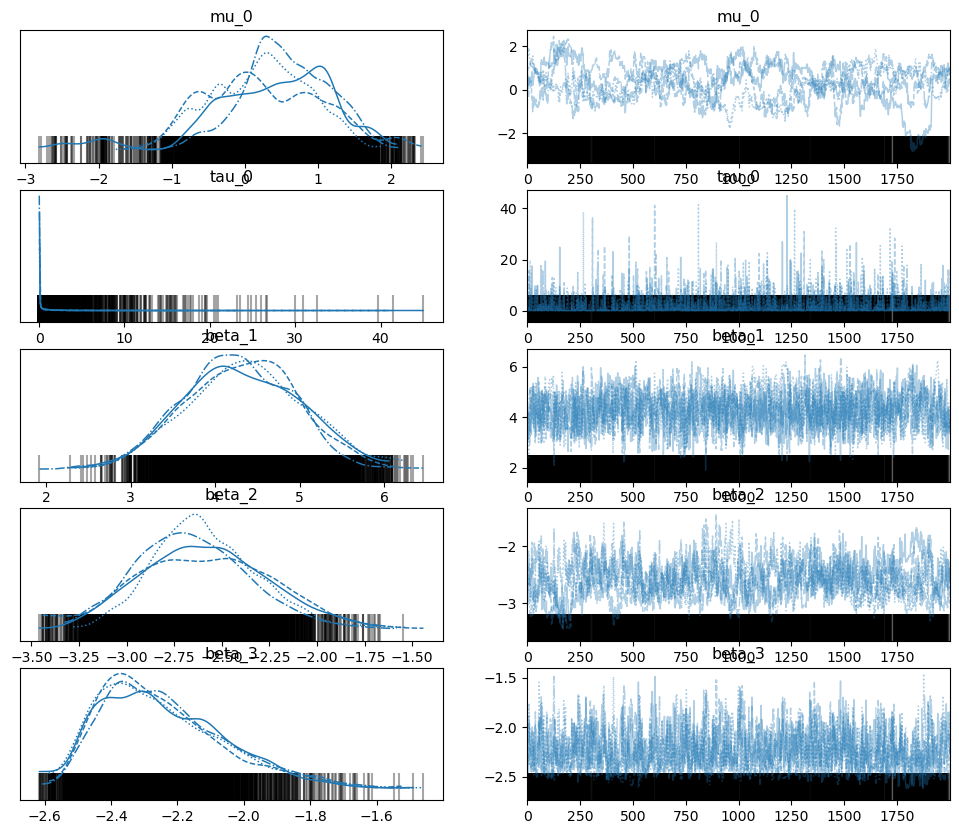

In [10]:
# your code here
var_names = ['mu_0','tau_0','beta_1', 'beta_2', 'beta_3']
az.plot_trace(trace, var_names=var_names)

In [11]:
summary = az.summary(trace, round_to=2)
print(summary[['r_hat']])

                 r_hat
mu_0              1.03
beta_0j[0]        1.02
beta_0j[1]        1.03
beta_0j[2]        1.02
beta_0j[3]        1.02
...                ...
beta_1            1.01
beta_2            1.02
beta_3            1.00
tau_0             1.00
sigma_0_squared   1.05

[66 rows x 1 columns]


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.4 - Inspecting Posteriors</b></div>

Plot histograms of the posterior distributions for the parameters $\beta_{0,9}$, $\beta_{0,19}$, $\beta_{0,29}$, ..., $\beta_{0,59}$. Are the actual parameters that you generated contained within these posterior distributions?

**Hint: The `az.plot_posterior()` function might be helpful here.**

_Type your answer here, replacing this text._

In [12]:
true_mu_0 = 2  
true_sigma_0 = 1   
true_beta_1 = 4 
true_beta_2 = -3   
true_beta_3 = -2  

N_districts = 60
true_beta_0j = np.random.normal(true_mu_0, true_sigma_0, N_districts)
print(true_beta_0j)

[ 2.3141139   4.09677807  1.67264481  2.65776176  2.89189077  2.25105413
  2.96043817  1.66425182  2.80286242  1.67367052  1.89677287  1.49740798
  1.4203108   2.27453852  1.15091246 -0.15903461 -0.795956    1.9340139
  1.63853762  0.71629319  1.21898273  0.02843346  1.61919488  2.09792559
  1.30026381  0.17860963  3.61788189  3.40888364  4.29576674  1.61744434
  1.21632266  0.38038144  1.40991181  2.93529315  2.31421054  0.84449727
  1.84164045  2.13624006  2.11763377  2.35989051  0.6560885   2.13552612
  1.33669503  2.26085401  3.12058914  1.59577374  1.14162969  1.98006486
  1.15559894  1.97184539  2.21152737 -0.09642772  0.69422543  0.58308737
  3.71827702  1.06785731  0.36278279  0.85859204  1.2529085   3.18043165]


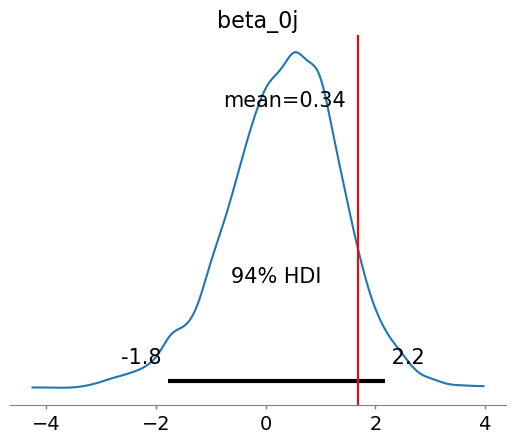

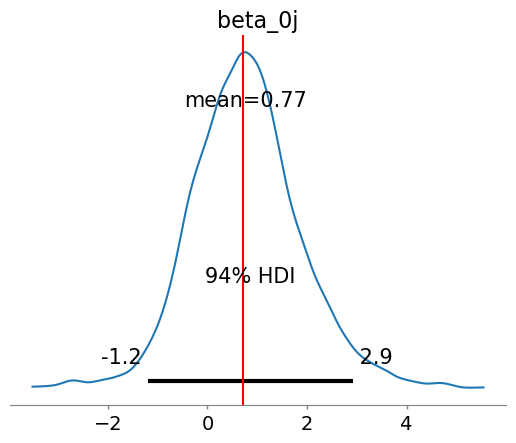

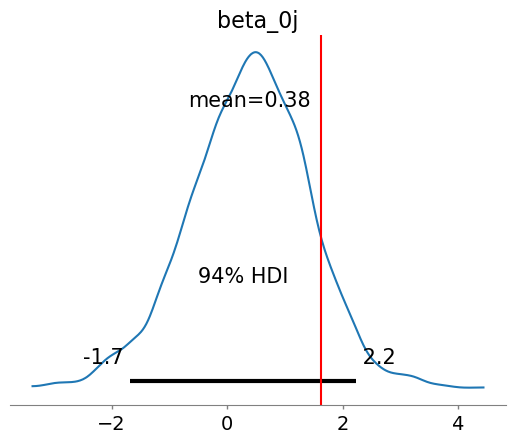

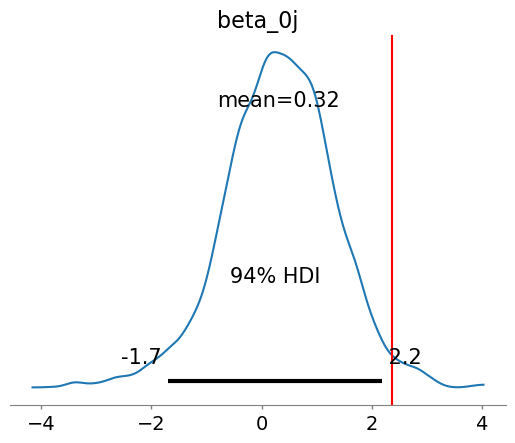

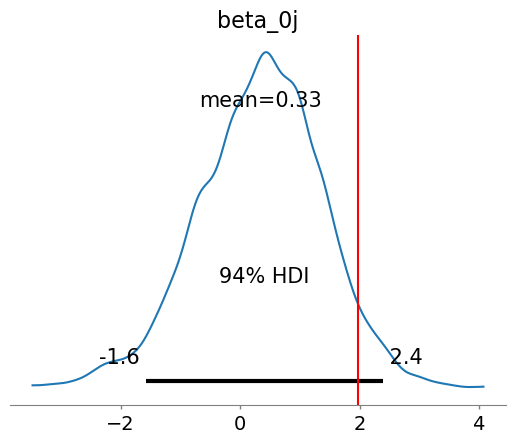

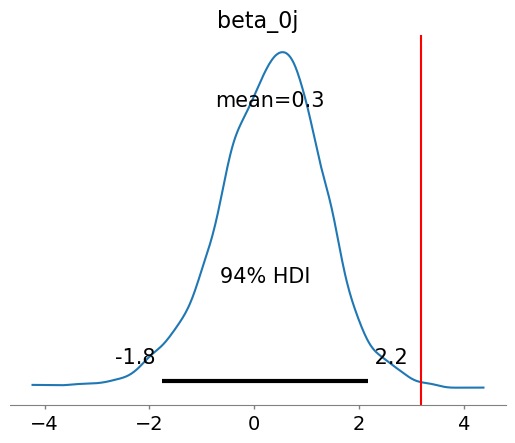

In [13]:
# your code here
district_indices = [9, 19, 29, 39, 49, 59]
true_beta_0j_values = [true_beta_0j[9],true_beta_0j[19],true_beta_0j[29],true_beta_0j[39],true_beta_0j[49],true_beta_0j[59]]  

for i, true_value in zip(district_indices, true_beta_0j_values):
    az.plot_posterior(trace, var_names=['beta_0j'], coords={'beta_0j_dim_0': i})
    plt.axvline(x=true_value, color='red')  
    plt.show()

<!-- END QUESTION -->

<a id="part2"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

### <div class='exercise'>Part 2: Varying-Intercept Model (Real Data)</div> 

[Return to contents](#contents)


<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.1 - Fit Varying-Intercept Model (Real Data)</b></div>

Now we'll fit our model to the *actual* data. Construct and fit the varying-intercept model to the real training data.

In [14]:
# your code here
district_codes = pd.Categorical(df_train['district']).codes
N_districts = len(np.unique(df_train['district']))

with pm.Model() as varying_intercept_model:
    mu_0 = pm.Normal('mu_0', mu=0, sigma=100)
    sigma_0_squared = 1/pm.Gamma('sigma_0_squared', alpha = 0.1, beta=0.1)
    sigma_0 =  pm.Deterministic('sigma_0', np.sqrt(sigma_0_squared))
    
    beta_0j = pm.Normal('beta_0j', mu=mu_0, sigma=np.sqrt(sigma_0_squared), shape=N_districts) 
    
    # Slopes
    beta_1 = pm.Normal('beta_1', mu=0, sigma=100)
    beta_2 = pm.Normal('beta_2', mu=0, sigma=100)
    beta_3 = pm.Normal('beta_3', mu=0, sigma=100)

    logit_p = beta_0j[district_codes] + beta_1 * df_train['urban'] + beta_2 * df_train['living.children'] + beta_3 * df_train['age_mean']
    
    Y_obs = pm.Bernoulli('Y_obs', p=pm.math.sigmoid(logit_p), observed=df_train['contraceptive_use'])

    trace = pm.sample(2000, tune=4000, target_accept=0.95)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_0, sigma_0_squared, beta_0j, beta_1, beta_2, beta_3]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 16 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [15]:
trace_q2=trace

In [16]:
pm.summary(trace)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_0,-1.600,0.246,-2.060,-1.142,0.013,0.009,359.0,716.0,1.02
beta_0j[0],-2.064,0.488,-2.993,-1.180,0.014,0.010,1146.0,2933.0,1.01
beta_0j[1],-2.124,0.372,-2.851,-1.466,0.015,0.011,599.0,1643.0,1.01
beta_0j[2],-1.769,0.484,-2.739,-0.917,0.014,0.010,1189.0,3493.0,1.00
beta_0j[3],-1.490,0.572,-2.585,-0.419,0.013,0.009,1904.0,4147.0,1.00
...,...,...,...,...,...,...,...,...,...
beta_1,0.739,0.161,0.449,1.047,0.003,0.002,3807.0,4808.0,1.00
beta_2,0.322,0.080,0.175,0.473,0.004,0.003,381.0,883.0,1.02
beta_3,-0.035,0.011,-0.057,-0.014,0.000,0.000,738.0,2064.0,1.01
sigma_0_squared,3.984,1.867,1.353,7.289,0.056,0.039,1232.0,2014.0,1.00


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.2 - Convergence Diagnostics</b></div>

Check the convergence by examining the trace plots and R-hats, as you did with the simulated data. What do you observe?

_Type your answer here, replacing this text._

In [17]:
# your code here
summary = az.summary(trace, round_to=2)
print(summary[['r_hat']])

                 r_hat
mu_0              1.02
beta_0j[0]        1.01
beta_0j[1]        1.01
beta_0j[2]        1.00
beta_0j[3]        1.00
...                ...
beta_1            1.00
beta_2            1.02
beta_3            1.01
sigma_0_squared   1.00
sigma_0           1.00

[66 rows x 1 columns]


array([[<Axes: title={'center': 'mu_0'}>,
        <Axes: title={'center': 'mu_0'}>],
       [<Axes: title={'center': 'sigma_0'}>,
        <Axes: title={'center': 'sigma_0'}>],
       [<Axes: title={'center': 'beta_1'}>,
        <Axes: title={'center': 'beta_1'}>],
       [<Axes: title={'center': 'beta_2'}>,
        <Axes: title={'center': 'beta_2'}>],
       [<Axes: title={'center': 'beta_3'}>,
        <Axes: title={'center': 'beta_3'}>]], dtype=object)

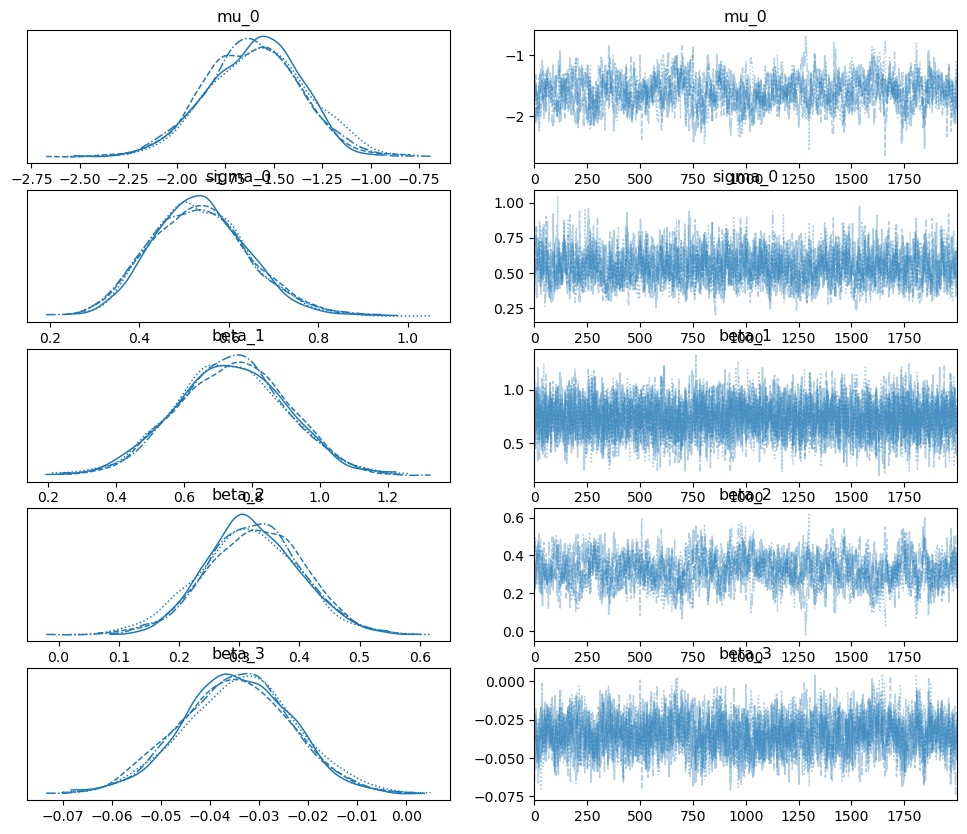

In [18]:
var_names = ['mu_0', 'sigma_0', 'beta_1', 'beta_2', 'beta_3']
az.plot_trace(trace, var_names=var_names)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.3 - Districts with Highest & Lowest Rates of Contraceptive Usage</b></div>

Based on the posterior means, which district has the highest base rate of contraceptive usage (independent of other factors like urban population)? Which district has the lowest? Explain how you arrived at these conclusions, interpreting any numerical values that played a role in your reasoning.

_Type your answer here, replacing this text._

In [19]:
summary_output =pm.summary(trace)
#print(summary_output)
beta_0j_means_df = summary_output[summary_output.index.str.startswith('beta_0j')]
#print(beta_0j_means_df)
highest_base_rate_district = beta_0j_means_df.loc[beta_0j_means_df['mean'].idxmax()]
lowest_base_rate_district = beta_0j_means_df.loc[beta_0j_means_df['mean'].idxmin()]
print("District with the highest base rate of contraceptive usage:")
print(highest_base_rate_district)

print("\nDistrict with the lowest base rate of contraceptive usage:")
print(lowest_base_rate_district)


District with the highest base rate of contraceptive usage:
mean           -0.694
sd              0.401
hdi_3%         -1.422
hdi_97%         0.073
mcse_mean       0.011
mcse_sd         0.008
ess_bulk     1221.000
ess_tail     3036.000
r_hat           1.010
Name: beta_0j[56], dtype: float64

District with the lowest base rate of contraceptive usage:
mean           -2.191
sd              0.530
hdi_3%         -3.217
hdi_97%        -1.246
mcse_mean       0.014
mcse_sd         0.010
ess_bulk     1321.000
ess_tail     3567.000
r_hat           1.000
Name: beta_0j[11], dtype: float64


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.4 - Varying Intercept? Conclusions from Posterior Samples</b></div>

What are the posterior means of $\mu_0$ and $\sigma_0$? Do these values offer any evidence in support of or against the varying-intercept model, compared to a model with a single intercept value for all districts? Explain why or why not.


**Hint:** Both ArviZ's `plot_posterior` and [`plot_forest()`](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_forest.html) functions will prove useful here.

_Type your answer here, replacing this text._

Posterior mean of mu_0: -1.6
Posterior mean of sigma_0: 0.535


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

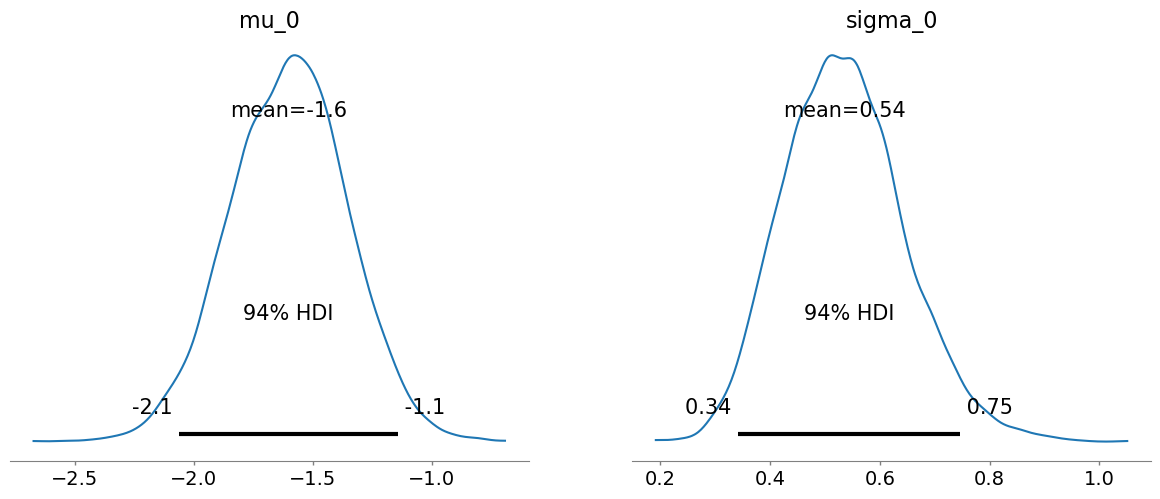

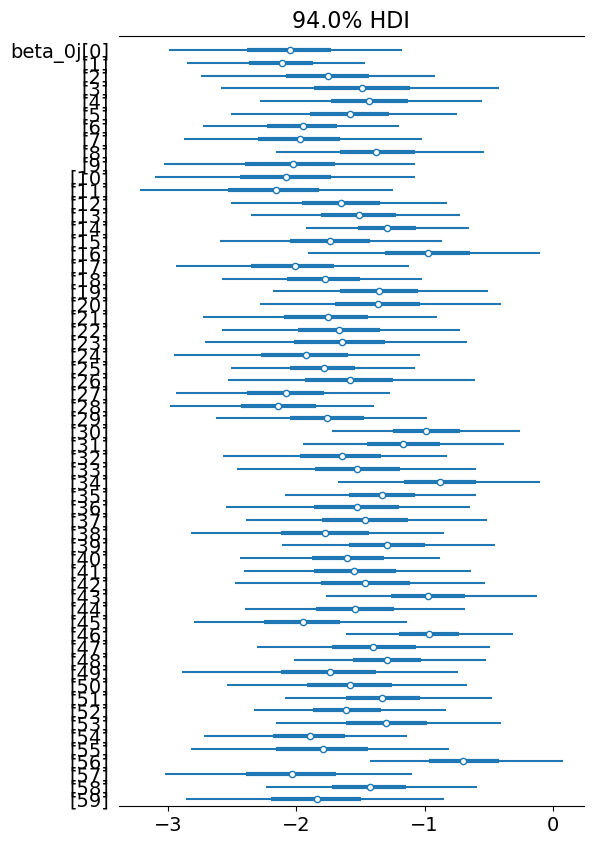

In [20]:
# your code here
mu_0_mean = summary_output.loc['mu_0', 'mean']
sigma_0_mean = summary_output.loc['sigma_0', 'mean']
print("Posterior mean of mu_0:", mu_0_mean)
print("Posterior mean of sigma_0:", sigma_0_mean)

# Posterior & Forest 
az.plot_posterior(trace, var_names=['mu_0', 'sigma_0'])
az.plot_forest(trace, var_names=['beta_0j'], combined=True, kind='forestplot')

<!-- END QUESTION -->

<a id="part3"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

## <div class='exercise'>Part 3: Varying-Coefficient Model</div> 

[Return to contents](#contents)


The next model we will fit to the contraceptives data is a **varying-coefficients logistic regression** model. Here, in addition to a varying intercept, the coefficients on `living.children`, `age_mean`, and `urban` also vary by district.

Prior distribution:

$$
\begin{split}
\beta_{0j} &\sim N(\mu_0,\sigma_0^2)\; \text{, with} \;\; \mu_0 \sim N(0,10000)\; \text{and} \; \; \frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)
\\
\beta_{1j} &\sim N(0,\sigma_1^2)\; \text{, with} \;\; \frac{1}{\sigma^2_1} \sim \text{Gamma}(0.1,0.1) 
\\
\beta_{2j} &\sim N(0,\sigma_2^2)\; \text{, with} \;\; \frac{1}{\sigma^2_2} \sim \text{Gamma}(0.1,0.1)
\\ 
\beta_{3j} &\sim N(0,\sigma_3^2)\; \text{, with} \;\; \frac{1}{\sigma^2_3} \sim \text{Gamma}(0.1,0.1)
\\
\end{split}
$$

Model for data:

$$
\begin{split}
Y_{ij} &\sim \text{Bernoulli}(p_{ij})
\\ \\
\text{logit}\:p_{ij} &= \beta_{0j} + \beta_{1j} \times \text{urban} + \beta_{2j} \times \text{living.children} + \beta_{3j} \times \text{age-mean}
\\ \\
\end{split}
$$

**PLEASE NOTE:**

* The name "varying coefficient model" is used here to distinguish the Q3 model from the "varying intercept" model in Q2, but observe from the specification about that **BOTH** intercepts *and* coefficients vary in this Q3 model.
* Once again, the $\text{Gamma}$ distribution uses the $\text{Gamma}(\alpha, \beta)$ parametrization, where $\alpha$ is the shape and $\beta$ is the rate. 

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.1 - Fit Varying Coefficient Model</b></div>

Fit the varying-coefficients model described above to the real training data.

In [21]:
# your code here

district_codes = pd.Categorical(df_train['district']).codes
N_districts = len(np.unique(df_train['district']))

with pm.Model() as varying_coefficients_model:
    mu_0 = pm.Normal('mu_0', mu=0, sigma=100)
    sigma_0_squared = pm.InverseGamma('sigma_0_squared', alpha=0.1, beta=0.1)
    sigma_0 = pm.Deterministic('sigma_0', np.sqrt(sigma_0_squared))

    sigma_1_squared = pm.InverseGamma('sigma_1_squared', alpha=0.1, beta=0.1)
    sigma_1 = pm.Deterministic('sigma_1', np.sqrt(sigma_1_squared))
    
    sigma_2_squared = pm.InverseGamma('sigma_2_squared', alpha=0.1, beta=0.1)
    sigma_2 = pm.Deterministic('sigma_2', np.sqrt(sigma_2_squared))
    
    sigma_3_squared = pm.InverseGamma('sigma_3_squraed', alpha=0.1, beta=0.1)
    sigma_3 = pm.Deterministic('sigma_3', np.sqrt(sigma_3_squared))
    

    beta_0j = pm.Normal('beta_0j', mu=mu_0, sigma=sigma_0, shape=N_districts)
    beta_1j = pm.Normal('beta_1j', mu=0, sigma=sigma_1, shape=N_districts)
    beta_2j = pm.Normal('beta_2j', mu=0, sigma=sigma_2, shape=N_districts)
    beta_3j = pm.Normal('beta_3j', mu=0, sigma=sigma_3, shape=N_districts)
    
   
    logit_p = beta_0j[district_codes] + beta_1j[district_codes] * df_train['urban'] + \
              beta_2j[district_codes] * df_train['living.children'] + beta_3j[district_codes] * df_train['age_mean']

    Y_obs = pm.Bernoulli('Y_obs', p=pm.math.sigmoid(logit_p), observed=df_train['contraceptive_use'])

    trace = pm.sample(2000, tune=4000, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_0, sigma_0_squared, sigma_1_squared, sigma_2_squared, sigma_3_squraed, beta_0j, beta_1j, beta_2j, beta_3j]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 31 seconds.


In [22]:
trace_q3 = trace

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.2 - Convergence Diagnostics</b></div>

Check the convergence of your varying-coefficients model by examining the trace plots and R-hats, as you did with the varying-intercept models earlier. What do you observe?

_Type your answer here, replacing this text._

In [23]:
# your code here
summary = az.summary(trace, var_names=['mu_0', 'sigma_0', 'sigma_1', 'sigma_2', 'sigma_3'])
print(summary[['r_hat']])

         r_hat
mu_0      1.01
sigma_0   1.01
sigma_1   1.01
sigma_2   1.00
sigma_3   1.00


array([[<Axes: title={'center': 'mu_0'}>,
        <Axes: title={'center': 'mu_0'}>],
       [<Axes: title={'center': 'sigma_0'}>,
        <Axes: title={'center': 'sigma_0'}>],
       [<Axes: title={'center': 'sigma_1'}>,
        <Axes: title={'center': 'sigma_1'}>],
       [<Axes: title={'center': 'sigma_2'}>,
        <Axes: title={'center': 'sigma_2'}>],
       [<Axes: title={'center': 'sigma_3'}>,
        <Axes: title={'center': 'sigma_3'}>],
       [<Axes: title={'center': 'beta_0j'}>,
        <Axes: title={'center': 'beta_0j'}>],
       [<Axes: title={'center': 'beta_1j'}>,
        <Axes: title={'center': 'beta_1j'}>],
       [<Axes: title={'center': 'beta_2j'}>,
        <Axes: title={'center': 'beta_2j'}>],
       [<Axes: title={'center': 'beta_3j'}>,
        <Axes: title={'center': 'beta_3j'}>]], dtype=object)

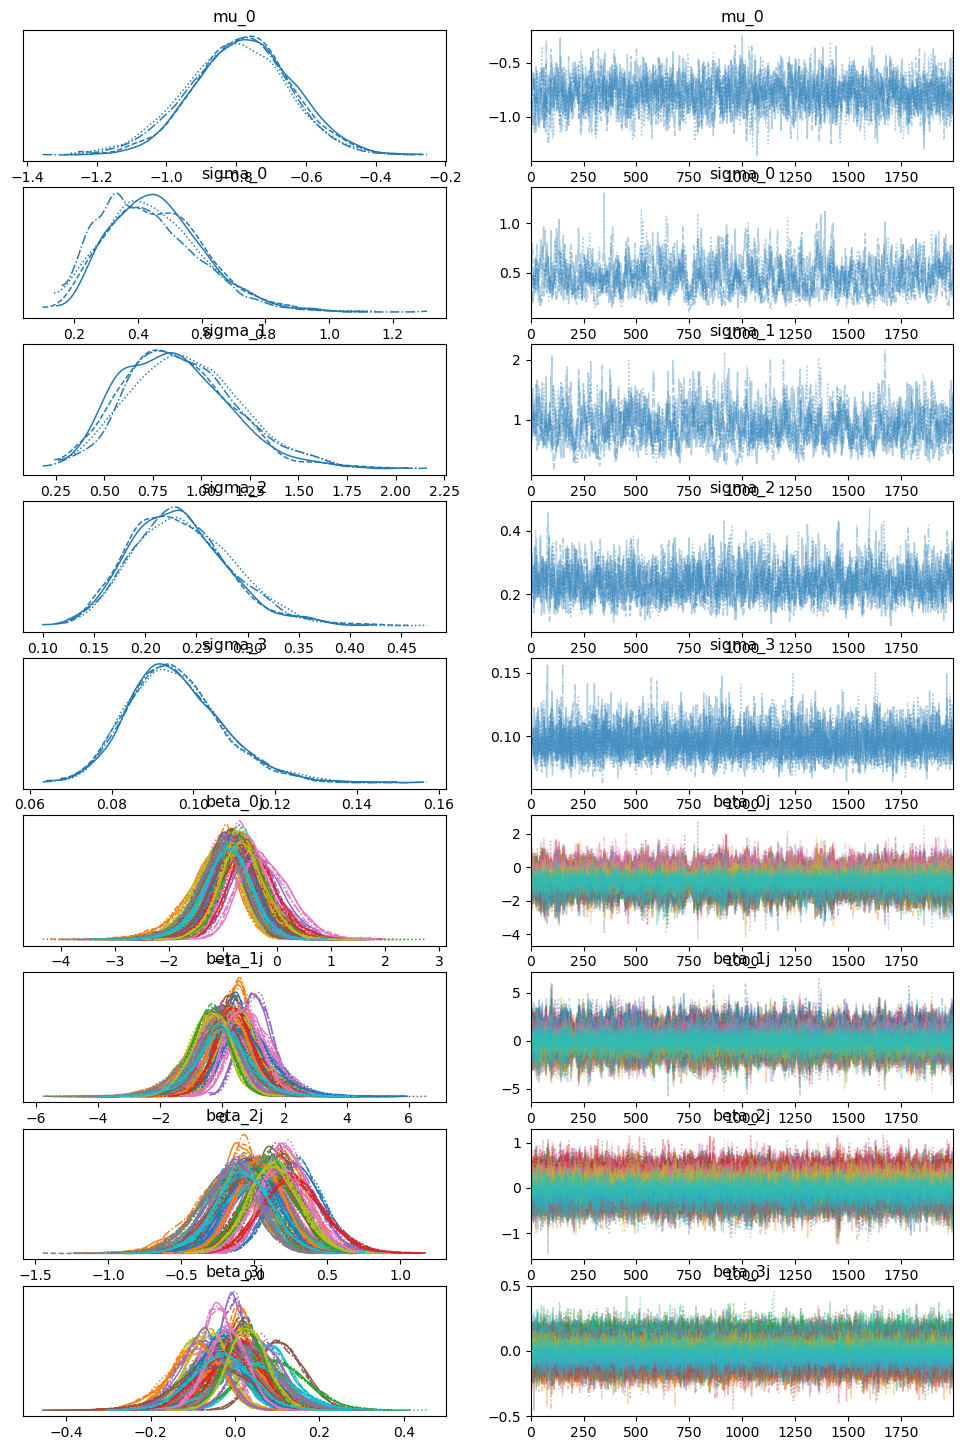

In [24]:
var_names = ['mu_0', 'sigma_0', 'sigma_1', 'sigma_2', 'sigma_3','beta_0j','beta_1j','beta_2j','beta_3j']
az.plot_trace(trace, var_names=var_names)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.3 - Distribution of Posterior Means & HDIs</b></div>

Plot the distributions of posterior means and the 95% highest posterior density intervals (HDIs) for the intercepts and coefficients for each district. What do you conclude from these graphs?

**HINT:** The ArviZ [`plot_forest()`](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_forest.html) function is very well-suited for this task.

_Type your answer here, replacing this text._

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

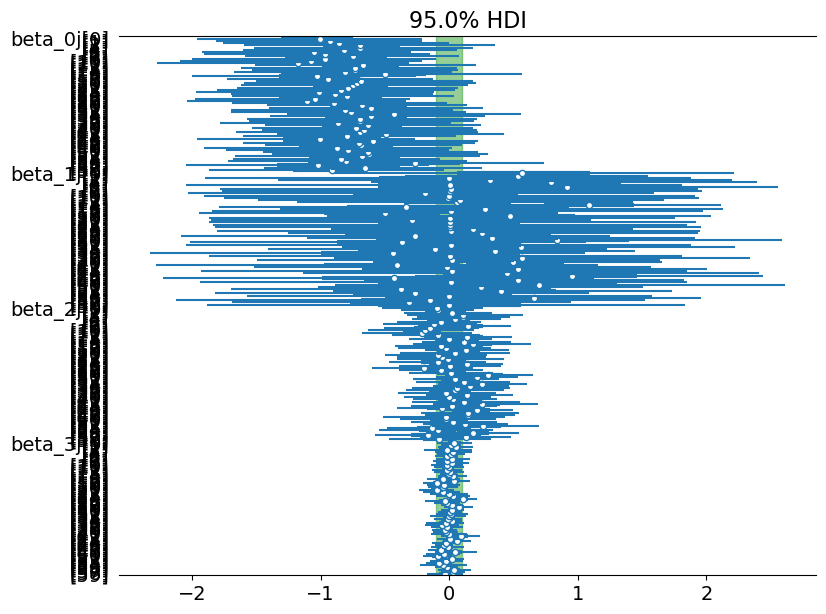

In [25]:
# your code here
var_names = ['beta_0j', 'beta_1j', 'beta_2j', 'beta_3j']

az.plot_forest(trace, var_names=var_names, combined=True,
               hdi_prob=0.95, rope=[-0.1, 0.1],
               kind='forestplot', figsize=(9, 7),
               ridgeplot_overlap=3, ridgeplot_truncate=False)

In [26]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_0,-0.788,0.142,-1.065,-0.527,0.004,0.003,1194.0,2104.0,1.01
beta_0j[0],-1.043,0.447,-1.888,-0.226,0.009,0.007,3039.0,2590.0,1.00
beta_0j[1],-0.948,0.401,-1.754,-0.224,0.006,0.005,3985.0,3329.0,1.00
beta_0j[2],-0.872,0.436,-1.753,-0.084,0.006,0.005,5003.0,3956.0,1.00
beta_0j[3],-0.672,0.492,-1.539,0.336,0.008,0.005,4490.0,3193.0,1.00
...,...,...,...,...,...,...,...,...,...
sigma_3_squraed,0.009,0.002,0.005,0.013,0.000,0.000,5696.0,5175.0,1.00
sigma_0,0.451,0.154,0.183,0.732,0.006,0.005,545.0,1125.0,1.01
sigma_1,0.890,0.283,0.358,1.392,0.011,0.008,589.0,961.0,1.01
sigma_2,0.235,0.048,0.144,0.322,0.001,0.001,1240.0,2762.0,1.00


<!-- END QUESTION -->

<a id="part4"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

## <div class='exercise'>Part 4: Predictions & Model Selection</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.1 - Create and Evaluate Classifiers</b></div>

Build two Bayesian logistic regression classifiers: one from your varying-intercept model (Q2) and another from your varying-coefficients model (Q3). Then, use each model to make predictions on your training and test sets.

* For each of the two classifiers, **on both train and test data separately**, report:
    * percentage of observations predicted to be `1` (i.e., uses contraceptives)
    * accuracy score

Finally, briefly describe the approach you used to implement these classifiers.
  
**Hint:** These classification models will make use of the samples generated by your PyMC models above, but they need not themselves be PyMC model objects. They can also be constructed out of simple Python functions of your own design.

_Type your answer here, replacing this text._

In [27]:
#note: intercept vary
district_codes_train =  pd.Categorical(df_train['district']).codes
district_codes_test = pd.Categorical(df_test['district']).codes
def generate_predictions(trace, dataset, district_codes, model_type='varying-intercept'):
    # Extracting samples
    beta_0j_samples = trace.posterior['beta_0j'].values.reshape(-1, trace.posterior['beta_0j'].shape[-1])

    n_samples = beta_0j_samples.shape[0]
    probs = []
    beta_1 = pm.summary(trace).loc['beta_1', 'mean']
    beta_2 = pm.summary(trace).loc['beta_2', 'mean']
    beta_3 = pm.summary(trace).loc['beta_3', 'mean']
    for i in range(n_samples):
        logit = beta_0j_samples[i][district_codes] + beta_1 * df_train['urban'] + beta_2 * df_train['living.children'] + beta_3 * df_train['age_mean']
        prob = expit(logit)
        probs.append(prob)

    # Averaging probabilities over all samples
    mean_probs = np.mean(probs, axis=0)
    return mean_probs > 0.5

def evaluate_model(predictions, actual):
    accuracy = np.mean(predictions == actual)
    percentage_ones = np.mean(predictions) * 100
    return accuracy, percentage_ones

train_preds_q2 = generate_predictions(trace_q2, df_train, district_codes_train, 'varying-intercept')
test_preds_q2 = generate_predictions(trace_q2, df_test, district_codes_test, 'varying-intercept')
accuracy_train_q2, percentage_ones_train_q2 = evaluate_model(train_preds_q2, df_train['contraceptive_use'])
accuracy_test_q2, percentage_ones_test_q2 = evaluate_model(test_preds_q2, df_test['contraceptive_use'])

print(f"Varying-Intercept Model - Train: Accuracy = {accuracy_train_q2*100:.2f}%, % Ones = {percentage_ones_train_q2:.2f}%")
print(f"Varying-Intercept Model - Test: Accuracy = {accuracy_test_q2*100:.2f}%, % Ones = {percentage_ones_test_q2:.2f}%")

Varying-Intercept Model - Train: Accuracy = 67.53%, % Ones = 22.44%
Varying-Intercept Model - Test: Accuracy = 58.53%, % Ones = 19.96%


In [28]:
#note: coefficient vary
district_codes_train =  pd.Categorical(df_train['district']).codes
district_codes_test = pd.Categorical(df_test['district']).codes
def generate_predictions(trace, dataset, district_codes, model_type='varying-coefficients'):
    # Extracting samples
    beta_0j_samples = trace.posterior['beta_0j'].values.reshape(-1, trace.posterior['beta_0j'].shape[-1])
    
    beta_1j_samples = trace.posterior['beta_1j'].values.reshape(-1, trace.posterior['beta_1j'].shape[-1])
    beta_2j_samples = trace.posterior['beta_2j'].values.reshape(-1, trace.posterior['beta_2j'].shape[-1])
    beta_3j_samples = trace.posterior['beta_3j'].values.reshape(-1, trace.posterior['beta_3j'].shape[-1])

    n_samples = beta_0j_samples.shape[0]
    probs = []
    for i in range(n_samples):
        logit = beta_0j_samples[i][district_codes]
        logit += (beta_1j_samples[i][district_codes] * dataset['urban'] +
                      beta_2j_samples[i][district_codes] * dataset['living.children'] +
                      beta_3j_samples[i][district_codes] * dataset['age_mean'])
        prob = expit(logit)
        probs.append(prob)

    # Averaging probabilities over all samples
    mean_probs = np.mean(probs, axis=0)
    return mean_probs > 0.5

train_preds_q3 = generate_predictions(trace_q3, df_train, district_codes_train, 'varying-coefficients')
test_preds_q3 = generate_predictions(trace_q3, df_test, district_codes_test, 'varying-coefficients')
accuracy_train_q3, percentage_ones_train_q3 = evaluate_model(train_preds_q3, df_train['contraceptive_use'])
accuracy_test_q3, percentage_ones_test_q3 = evaluate_model(test_preds_q3, df_test['contraceptive_use'])
print(f"Varying-Coefficients Model - Train: Accuracy = {accuracy_train_q3*100:.2f}%, % Ones = {percentage_ones_train_q3:.2f}%")
print(f"Varying-Coefficients Model - Test: Accuracy = {accuracy_test_q3*100:.2f}%, % Ones = {percentage_ones_test_q3:.2f}%")

Varying-Coefficients Model - Train: Accuracy = 70.22%, % Ones = 26.99%
Varying-Coefficients Model - Test: Accuracy = 62.15%, % Ones = 26.47%


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.2 - Comparison to Naive Model</b></div>

Report the same four metrics from the previous question for a 3rd, "naive" model that always predicts the most frequent outcome observed in the training data.

In [29]:
# your code here

#Naive Model 
most_frequent_outcome = df_train['contraceptive_use'].mode()[0]
print(most_frequent_outcome)

def evaluate_naive_model(dataset, most_frequent_outcome):
    predictions = np.full(len(dataset), most_frequent_outcome)
    actual = dataset['contraceptive_use']
    accuracy = np.mean(predictions == actual)
    percentage_ones = np.mean(predictions) * 100
    return accuracy, percentage_ones

accuracy_train_naive, percentage_ones_train_naive = evaluate_naive_model(df_train, most_frequent_outcome)
accuracy_test_naive, percentage_ones_test_naive = evaluate_naive_model(df_test, most_frequent_outcome)
print(f"Naive Model - Train: Accuracy = {accuracy_train_naive*100:.2f}%, % Ones = {percentage_ones_train_naive:.2f}%")
print(f"Naive Model - Test: Accuracy = {accuracy_test_naive*100:.2f}%, % Ones = {percentage_ones_test_naive:.2f}%")


0
Naive Model - Train: Accuracy = 61.01%, % Ones = 0.00%
Naive Model - Test: Accuracy = 60.50%, % Ones = 0.00%


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.3 - Model Selection</b></div>

What do you conclude from the results of 4.1 & 4.2? Which model appears to be the best (i.e. varying-intercept, varying-coefficient, or naive), and what is your rationale?

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.4 Wrap-up</b></div>

* In a few sentences, please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation.

* How many hours did you spend working on this assignment? Store this as an int or float in `time_spent_on_hw`

_The hardest question I think is the Q4. It is challengin as initially I wasn't quite sure what the question wants me to do in respect of the prediction and evaluation and later I realized I need to write additional functions. The implementations instructions are not very clear initially and I gradually figured out._

In [30]:
time_spent_on_hw = 15 

In [31]:
grader.check("q4.4")

q4.4 results: All test cases passed!

<!-- END QUESTION -->



In [32]:
time_end = time.time()
print(f"It took {(time_end - time_start)/60:.2f} minutes for this notebook to run")

It took 2.53 minutes for this notebook to run


**This concludes HW2. Thank you!**